Content in this file follow book: Hands-On Machine Learning with Scikit-Learn and TensorFlow by Aurélien Géron.

# Look at the big picture

# Get data

In [2]:
import pandas as pd

df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200,NEAR BAY


Then we take a look of data type in housing dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


### Comments:
- type of almost data column is float except ocean_proximity
- With total_bedrooms, we just have 20433 elements

In [4]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

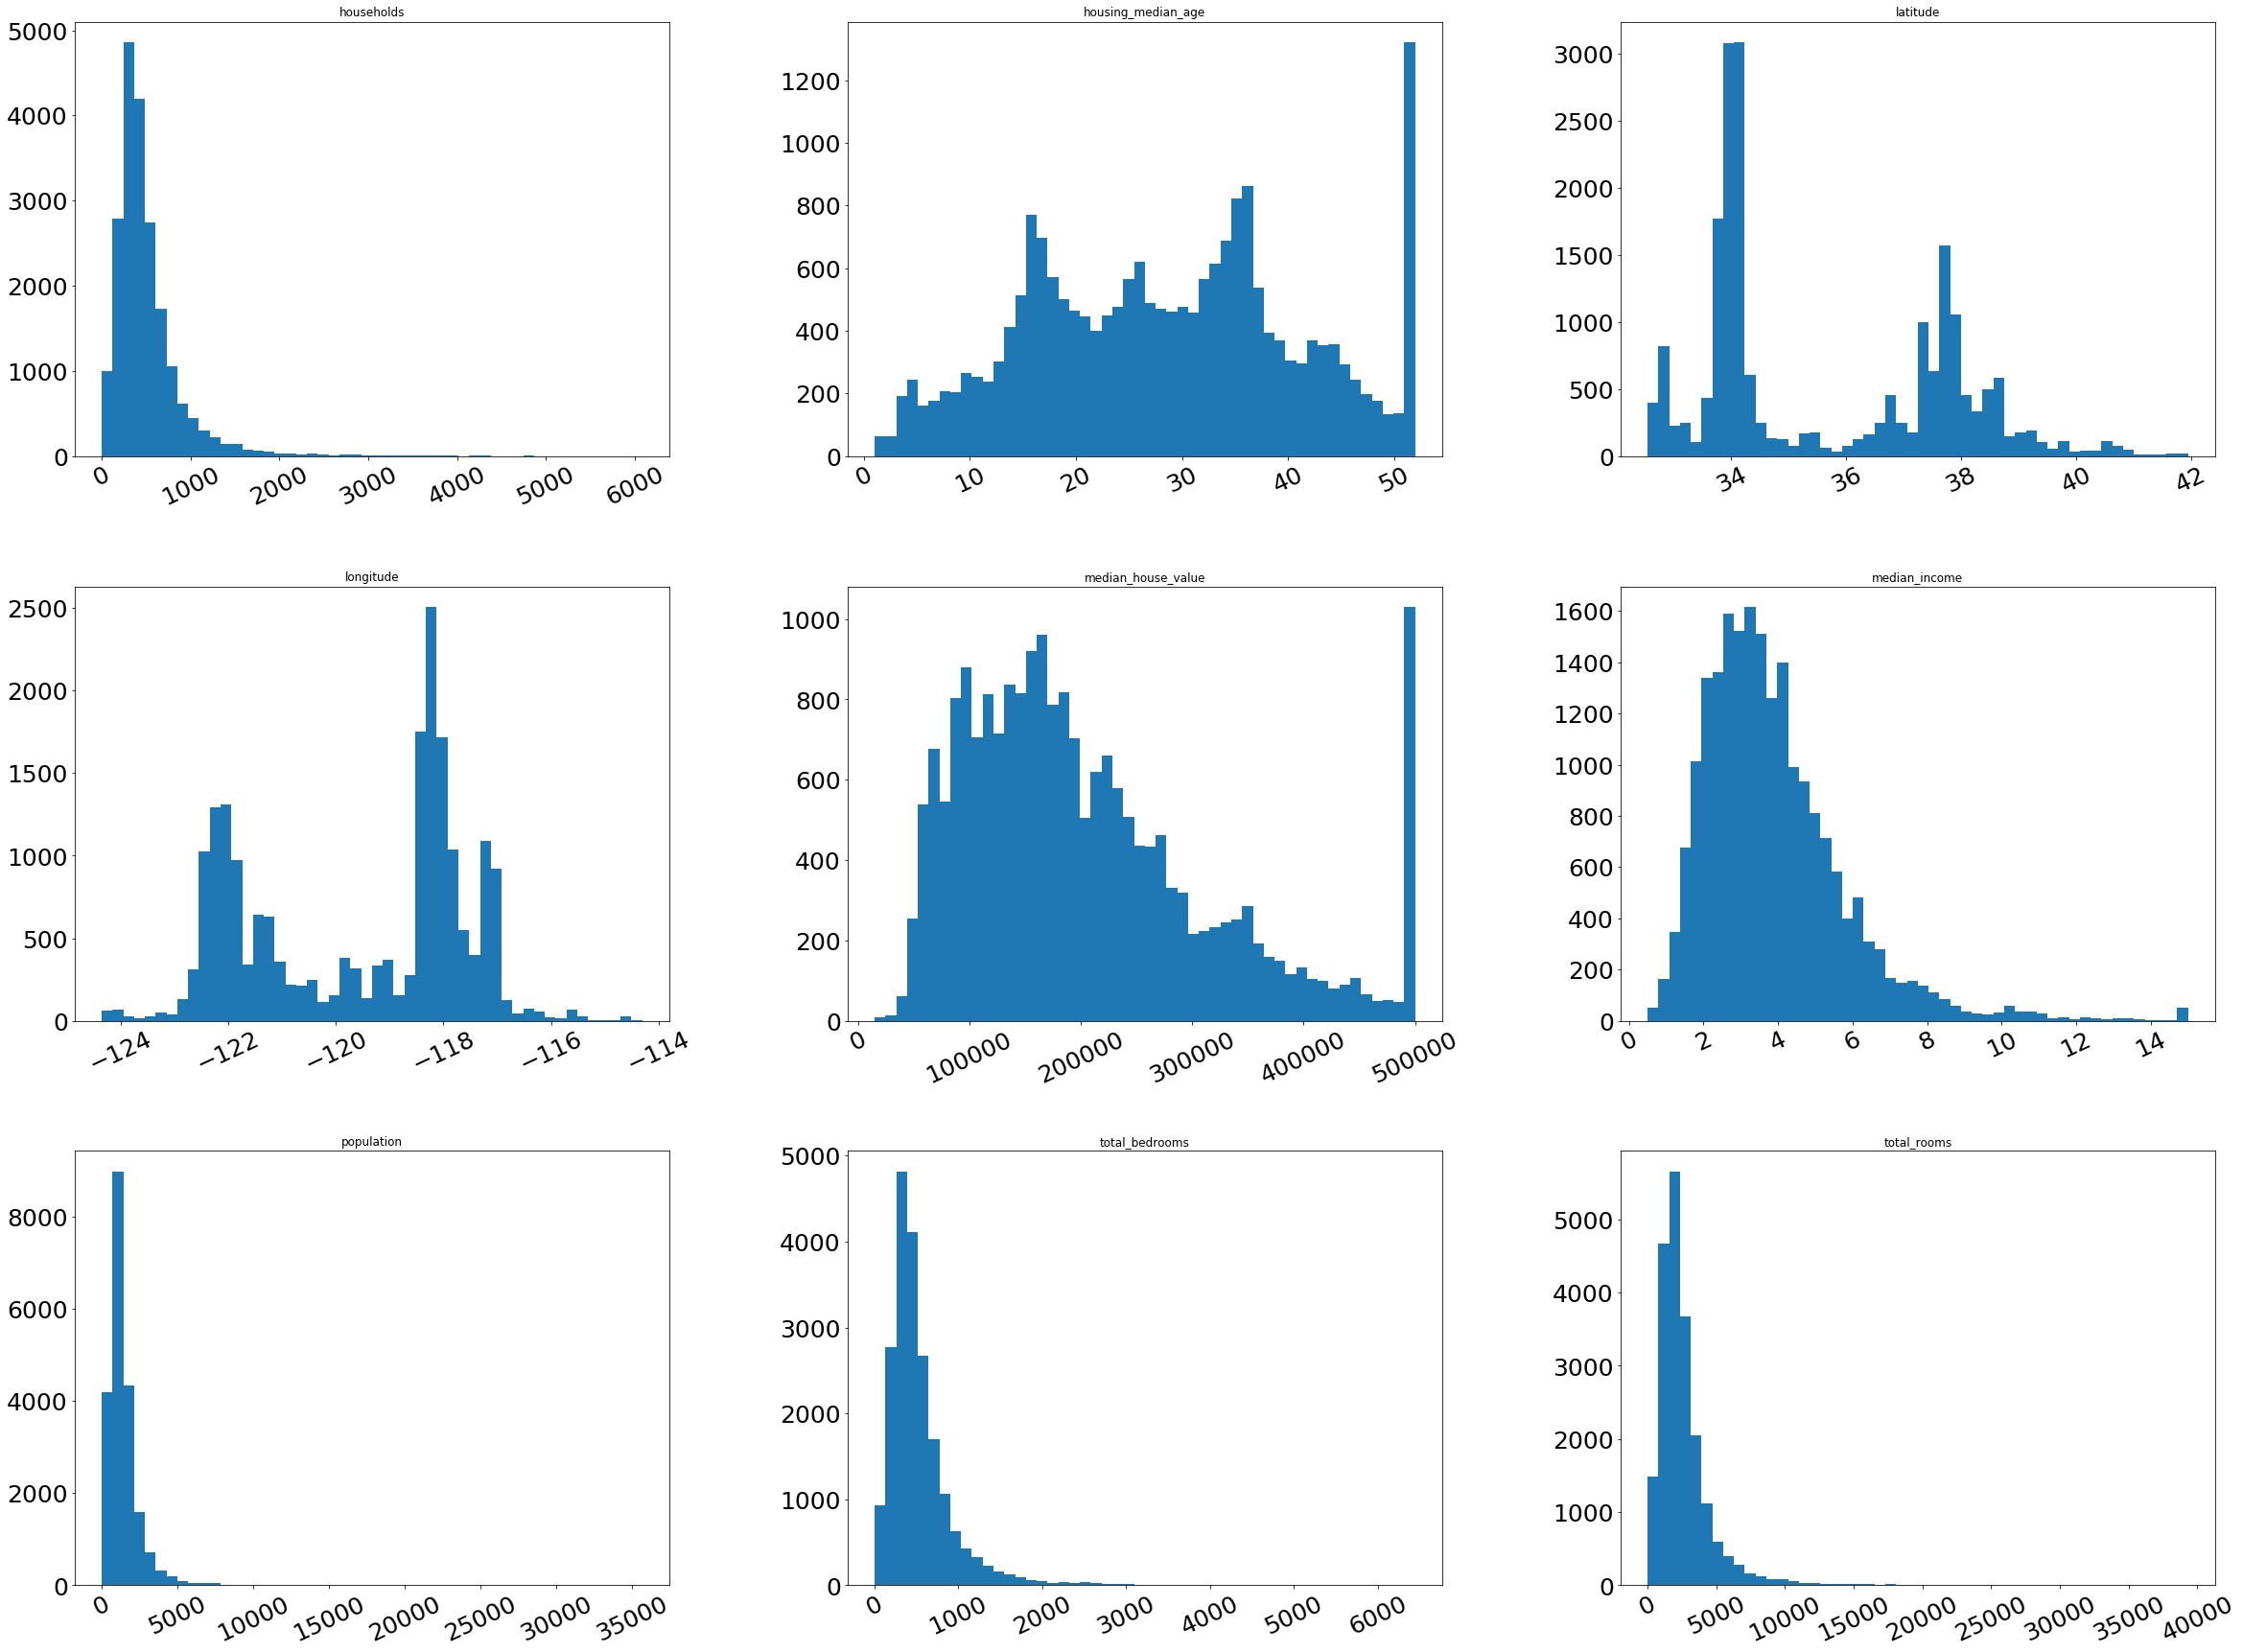

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins = 50, figsize = (40, 30), grid = False,
                xlabelsize = 25, ylabelsize = 25, xrot = 25)
plt.show()

### Comments:
- Median income does not look like it is expressed in US dollars
- housing_median_age limit at 50 and median_house_value limit at 500000
- shape of population, total_bedrooms, total_room and household is similar ( skewed positive)

In [6]:
import numpy as np

# def split_data (data_frame, ratio, seed = None):
#     number_observer = len(data_frame)
#     np.random.seed(seed)
#     msk = np.random.rand(number_observer) < ratio
#     train = house_data[msk]
#     test = house_data[~msk]
#     print('train size: {}, test size: {}'.format(np.shape(train),np.shape(test)))
#     return train, test

# train_set, test_set = split_data(house_data, 0.8, 1993)

Another way to create test set is use np.random.permutation or train_test_split sk learn


### Make sure test data is good enough
- For example, income have greate impact to house_value. So we need to cover all income segment in train_data and test_data

In [7]:
df['income_cat'] = np.ceil(df['median_income'] / 1.5)
# we can see in median_income hist. income is mainly distributing between 2 and 6, so we will cover income > 5 to 5
df['income_cat'].where(df['income_cat'] < 5, 5.0, inplace = True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 1993)

for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

for set in (strat_test_set, strat_train_set):
    set.drop(['income_cat'], axis = 1, inplace = True)

/home/mmr/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Discover and Visualize the Data to Gain Insights

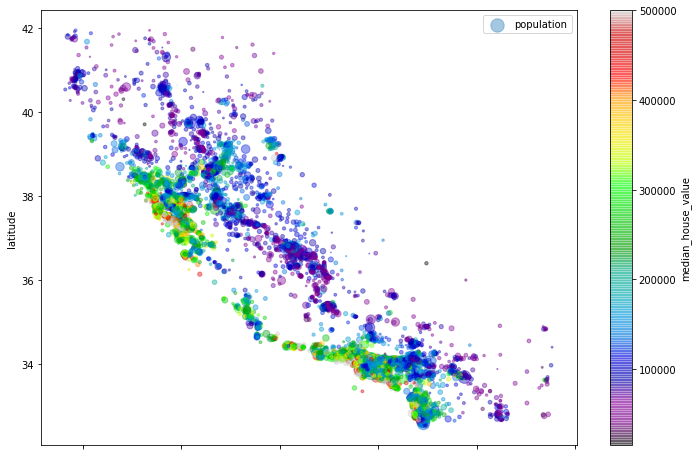

In [8]:
# make a copy to avoid making harmful train_set
train_set = strat_train_set.copy()
train_set.plot(kind = 'scatter', x = "longitude", y = "latitude", alpha = 0.4,
                figsize = (12, 8), s = df['population']/100,
                c = 'median_house_value', cmap = plt.get_cmap("nipy_spectral"),
                label = "population", colorbar = True)
plt.legend()

- We can see median_house_value is very much related to location
- Next we need to know correlation between features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb8ccda518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7feb87b04780>]], dtype=object)

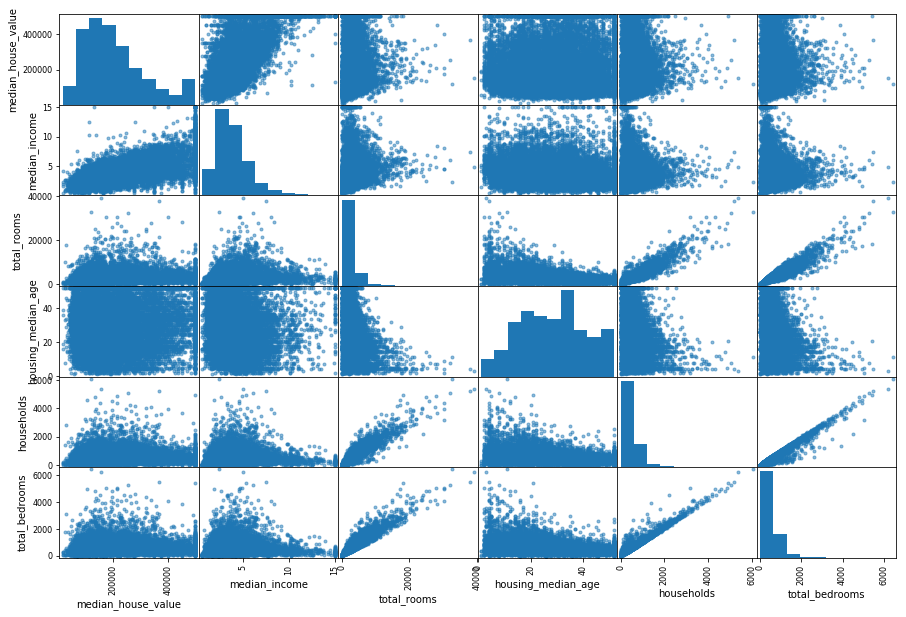

In [9]:
from pandas.tools.plotting import scatter_matrix
attr = ['median_house_value', 'median_income', 'total_rooms',
       'housing_median_age', 'households', 'total_bedrooms']
scatter_matrix(df[attr], figsize = (15, 10))

### Comment:
- we can see it have a relation between median_income and median_house_vlue
- total_rooms ~ households ~ total_bedrooms. Let's guest reason?
total room will increase when households increase, and it similar for total_bedrooms. But three of them don't have a greate impact to house_value. So we need to change a little bit to make it more useful

In [10]:
train_set['rooms_per_house'] = train_set['total_rooms'] / train_set['households']
train_set['bedrooms_per_room'] = train_set['total_bedrooms'] / train_set['total_rooms']
train_set['population_per_house'] = train_set['population'] / train_set['households']

Now, let's see a change

In [11]:
corr = np.abs(train_set.corr()['median_house_value'])
corr.sort_values(ascending = False)

median_house_value      1.000000
median_income           0.689189
bedrooms_per_room       0.254052
rooms_per_house         0.147074
latitude                0.145192
total_rooms             0.132644
housing_median_age      0.108757
households              0.062884
total_bedrooms          0.047098
longitude               0.045914
population              0.028947
population_per_house    0.027260
Name: median_house_value, dtype: float64

Maybe we will ignore population_per_house, it's not sense than population
# Prepare the Data for Machine Learning Algorithms

In [12]:
train_X = strat_train_set.drop(["median_house_value"],
                                axis = 1)
train_y = strat_train_set["median_house_value"]

In [13]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, houses_ix = 3, 4, 6
class AddFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, drop_old_columns = False):
        self.drop_old_columns = drop_old_columns
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_house = X[:,rooms_ix] / X[:,houses_ix]
        bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
        if self.drop_old_columns:
            return np.c_[X[X.columns.difference([rooms_ix,
                                                bedrooms_ix,
                                                houses_ix])],
                         rooms_per_house, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_house, bedrooms_per_room]


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)


num_attr = list(train_X.drop("ocean_proximity", axis = 1))
cat_attr = ["ocean_proximity"]

num_pipeline = Pipeline([("selector", DataFrameSelector(num_attr)),
                         ("imputer", Imputer(strategy = "median")),
                         ("standard", StandardScaler()),
                         ("addNew", AddFeatures())
])
cat_pipeline = Pipeline([("selector", DataFrameSelector(cat_attr)),
                         ("LabelBinarizer", CustomLabelBinarizer()),
])
full_pipeline = FeatureUnion(transformer_list = [("num_pipeline", num_pipeline),
                                                 ("cat_pipeline", cat_pipeline),
])

In [14]:
train_data = full_pipeline.fit_transform(train_X)
train_labels = train_y

# Select and train model

In [15]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(train_data, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
some_data = train_data[:5]
some_labels = train_labels[:5]

In [17]:
predic_labels_LN = linear.predict(some_data)

In [18]:
from sklearn.metrics import mean_squared_error
mse_LN = np.sqrt(mean_squared_error(some_labels, predic_labels_LN))

In [19]:
mse_LN

35884.694661656256

In [20]:
from sklearn.tree import DecisionTreeRegressor
tree_re = DecisionTreeRegressor()
tree_re.fit(train_data, train_labels)
predic_labels_DT = tree_re.predict(some_data)
mse_DT = np.sqrt(mean_squared_error(some_labels, predic_labels_DT))

In [21]:
mse_DT

0.0

???cross-validation

In [33]:
from sklearn.model_selection import cross_val_score
scores_DT = cross_val_score(tree_re, train_data, train_labels,
                        cv = 10, scoring = "neg_mean_squared_error")
mse_CV_DT = np.sqrt(-scores_DT)

In [37]:
print(mse_CV_DT, np.mean(mse_CV_DT), np.std(mse_CV_DT))

[ 71746.66865853  69746.43101539  70761.47988263  74524.41719744
  68879.08379482  67587.6038369   70345.88091545  70974.26193329
  66877.96466341  69155.94078694] 70059.9732685 2067.21678105


In [35]:
scores_LN = cross_val_score(linear, train_data, train_labels,
                           cv = 10, scoring = "neg_mean_squared_error")
mse_CV_LN = np.sqrt(-scores_LN)

In [38]:
print(mse_CV_LN, np.mean(mse_CV_LN), np.std(mse_CV_LN))

[ 70234.35163283  68026.1111371   72219.92549429  71374.11303735
  65504.09489741  68312.9498326   67266.18502091  69010.69488703
  67786.77564684  68370.77459084] 68810.5976177 1889.05110776


In [39]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(train_data, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [49]:
scores_RF = cross_val_score(forest_reg, train_data, train_labels,
                           cv = 10, scoring = "neg_mean_squared_error")
predict_labels_RF = forest_reg.predict(some_data)
mse_RF = np.sqrt(mean_squared_error(predict_labels_RF, some_labels))

In [50]:
print(mse_CV_RF, np.mean(mse_CV_RF), np.std(mse_CV_RF))
print(mse_RF)

[ 53504.59162686  52595.11275772  52051.64863048  54131.10582238
  50195.37443673  51845.72282556  50085.3148685   51928.11673692
  50718.96851315  52064.50396322] 51912.0460182 1252.2675191
13114.7995182
